In [10]:
%matplotlib inline
import random
import torch
import matplotlib.pyplot as plt
import numpy

In [7]:
# 根据带有噪声的线性模型构造一个人造数据集.使用线性模型参数w=[2,-3.4]T 、b=4.2和噪声项生成数据集及其标签：
#     y = Xw + b + e
# 你可以将视为模型预测和标签时的潜在观测误差。 在这里我们认为标准假设成立，即服从均值为0的正态分布。 为了简化问题，我们将标准差设为0.01。 下面的代码生成合成数据集

In [8]:
def synthetic_data(w, b, num_examples):
    ''' 生成 y = Xw + b + 噪声。'''
    X = torch.normal(0,1, (num_examples,len(w)))   # torch.normal(均值，方差，样本大小（样本个数，样本的列数）) 
    y = torch.matmul(X, w) + b 
    y += torch.normal(0, 0.01, y.shape)
    return X,y.reshape((-1,1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [12]:
# features中的每一行都包含一个二维数据样本， labels中的每一行都包含一维标签值（一个标量）。
print('features:',features[0],'\nlabel:',labels[0])

features: tensor([-0.5409, -0.3053]) 
label: tensor([4.1565])


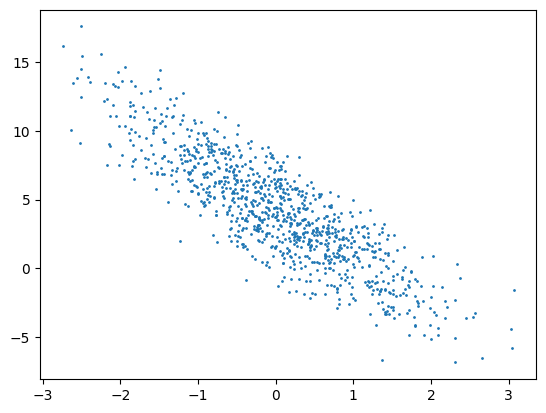

In [13]:
plt.figure()
plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)

## 线性回归从零实现 

### 训练模型时要对数据集进行遍历，每次抽取一小批量样本，并使用它们来更新我们的模型。 由于这个过程是训练机器学习算法的基础，所以有必要定义一个函数， 该函数能打乱数据集中的样本并以小批量方式获取数据。
### 定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。

In [17]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
        indices[i:min(i+batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]   # 产生随机顺序的特征以及随机顺序所对应的标签

        
# 读取第一个小批量数据样本并打印。 每个批量的特征维度显示批量大小和输入特征数。 同样的，批量的标签形状与batch_size相等
batch_size = 10

for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-2.0369, -2.1730],
        [-2.0231,  0.8116],
        [ 0.4261,  0.8551],
        [ 0.2290,  0.1696],
        [ 0.0480,  0.8196],
        [-0.1605, -1.1703],
        [-0.5926,  0.0343],
        [ 1.3403,  0.6840],
        [ 0.6609, -0.8566],
        [-0.4877, -0.6932]]) 
 tensor([[ 7.5056],
        [-2.5963],
        [ 2.1253],
        [ 4.0658],
        [ 1.5343],
        [ 7.8405],
        [ 2.8952],
        [ 4.5589],
        [ 8.4328],
        [ 5.5695]])


### 定义初始化模型参数

In [39]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad = True)

##### 定义模型

In [40]:
def linreg(X, w, b):
    '''线性回归模型'''
    return torch.matmul(X, w) + b

### 定义损失函数

In [41]:
def squared_loss(y_hat, y):
    '''均方损失'''
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

 ### 定义优化算法 

In [42]:
def sgd(params, lr, batch_size):
    '''小批量随机梯度下降'''
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练过程

In [43]:
lr = 0.03   # 学习率
num_epochs = 3    # 全扫数据三次
net = linreg       # 模型
loss = squared_loss    # 损失函数

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)    # 'X'和'y'的小批量损失
        # 因为'l'形状是('batch_size', 1),而不是一个标量。
        # 并以此计算关于['w','b']的梯度
        l.sum().backward()
        sgd([w,b], lr, batch_size)   # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.038674
epoch 2, loss 0.000152
epoch 3, loss 0.000051


### 比较真实参数和通过训练学到的参数来评估训练的成功程度

In [44]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0001, -0.0005], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0013], grad_fn=<RsubBackward1>)


## 线性回归简洁实现

In [45]:
import numpy as np
import torch
from torch.utils import data

###  生成数据集

In [46]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

### 读取数据集

In [47]:
# 调用框架中现有的API来读取数据
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)  # shuffle = is_train指需要打乱顺序

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[ 0.9485, -1.3108],
         [ 0.0997,  0.0574],
         [-0.1697,  0.2039],
         [ 0.1793,  1.4314],
         [ 1.1399, -0.2776],
         [-0.2617, -2.7555],
         [-0.1051, -1.2162],
         [ 2.2318,  0.6140],
         [-0.5446, -1.5419],
         [-0.9825,  0.6405]]),
 tensor([[10.5451],
         [ 4.1915],
         [ 3.1576],
         [-0.3035],
         [ 7.4147],
         [13.0383],
         [ 8.1092],
         [ 6.5813],
         [ 8.3387],
         [ 0.0561]])]

### 使用框架的预定义好的层

In [48]:
# nn是神经网络的缩写
from torch import nn
# 在PyTorch中，全连接层在Linear类中定义。 值得注意的是，我们将两个参数传递到nn.Linear中。 第一个指定输入特征形状，即2，第二个指定输出特征形状，输出特征形状为单个标量，因此为1。
net = nn.Sequential(nn.Linear(2, 1))  

### 初始化模型参数

In [ ]:
#  正如我们在构造nn.Linear时指定输入和输出尺寸一样， 现在我们能直接访问参数以设定它们的初始值。 我们通过net[0]选择网络中的第一个图层， 然后使用weight.data和bias.data方法访问参数。 我们还可以使用替换方法normal_和fill_来重写参数值。
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

### 定义损失函数

In [49]:
# 计算均方误差使用的是MSLoss类，也称为平方L2范数
loss = nn.MSELoss()

### 定义优化算法

In [51]:
# 实例化SGD 实例
trainer = torch.optim.SGD(net.parameters(), lr=0.03)    # 优化w，b参数

### 训练

In [52]:
# 训练过程代码与我们从零开始实现时所做的非常相似
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter: 
        l = loss(net(X) ,y)    # net()里面自带了模型参数
        trainer.zero_grad()   # 优化器梯度清零
        l.backward()        # pytorch已经求过sum了，就只需求梯度
        trainer.step()      # 进行模型更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000209
epoch 2, loss 0.000102
epoch 3, loss 0.000101
